In [136]:
import os

import pandas as pd
import scipy as sp
import scipy.signal

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('ArmCuff15.txt', header=None, sep=' ')[[1, 3]]
df.columns = ['cuff', 'osc']
df.head()

,cuff,osc
0,159,691
1,159,697
2,159,702
3,158,703
4,158,708


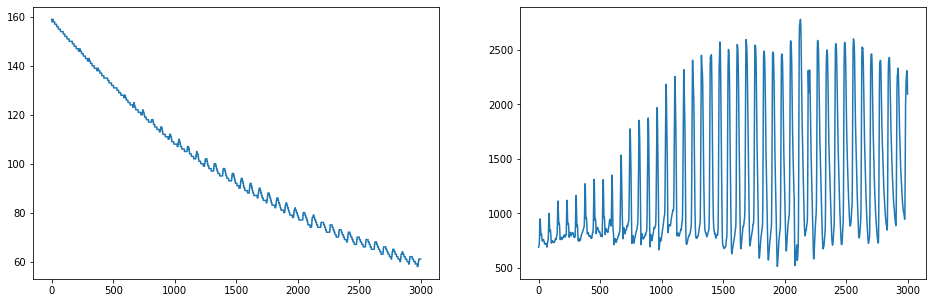

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axs[0].plot(df['cuff'])
axs[1].plot(df['osc']);

## Применение ФВЧ
Попробуем сделать вид, что работаем с данными от нашего АЦП. Для этого применим к сигналу давления цифровой ФВЧ 2-го порядка с такой же частотой среза, как и на схеме. Должно получиться что-то похожее на вторую колонку исходных данных.

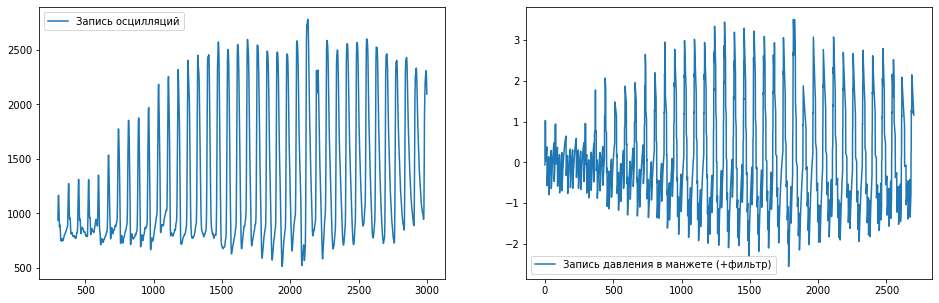

In [132]:
N = 2  # порядок
Wn = 0.5  # частота среза
sos = sp.signal.butter(N, Wn, btype='highpass', fs=85, output='sos')
filtered = sp.signal.sosfilt(sos, df['cuff'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

axs[0].plot(df['osc'][300:], label='Запись осцилляций')
axs[1].plot(filtered[300:], label='Запись давления в манжете (+фильтр)');
        
for ax in axs:
    ax.legend()

...close enough.

## Амплитудный метод

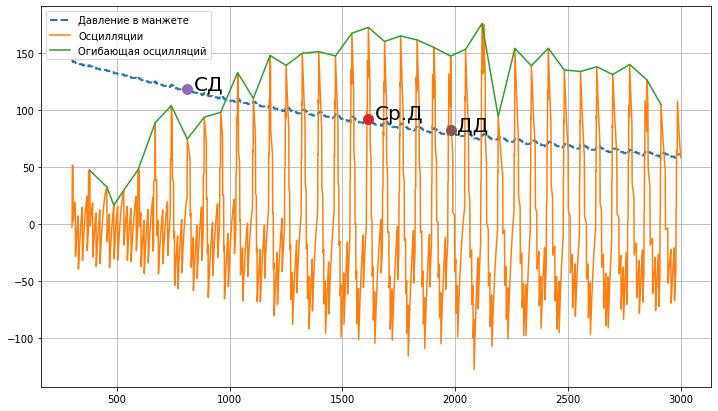

In [154]:
def filter_osc(cuff):
    N = 2  # порядок
    Wn = 0.5  # частота среза
    sos = sp.signal.butter(N, Wn, btype='highpass', fs=85, output='sos')
    return sp.signal.sosfilt(sos, cuff)

def calculate_pressure(cuff_pressure, plots=True, sp_coef=0.4):
    
    offset = 300
    filtered = filter_osc(cuff_pressure)
    filtered_cutoff = filtered[offset:]
    
    # построение ломанной огибающей - проходим по значениям 
    # осцилляций скользящим окном и ищем пики
    peaks = []
    peak_index = []
    window_size = 20
    for i in range(window_size, len(filtered_cutoff) - window_size):
        cur = filtered_cutoff[i]
        if max(filtered_cutoff[i-window_size:i+window_size+1]) == cur:
            peaks.append(cur)
            peak_index.append(i)
    peaks = np.array(peaks)
    peak_index = np.array(peak_index)

    # Вычисление среднего давления - максимальная амплитуда осцилляций
    # + устойчивость к помехам...
    up_flag = False
    map_flag = False
    map_peak = None
    step = 5
    for i, (index, p) in enumerate(zip(peak_index, peaks)):
        if not up_flag and peaks[i+1] < p:
            continue
        elif not up_flag:
            up_flag = True
        else:
            try:
                if max(peaks[i:i+step]) == p:
                    if not map_flag:
                        map_flag = True
                        map_index_df = index
                        map_peak = p
            except IndexError:
                break
    MAP = cuff_pressure[offset + map_index]

    # Вычисление систолического давления 
    # - находим пик, амплитуда которого наиболее похожа
    # на максимальную * sp_coef 
    # (по разным источникам sp_coef может быть равен 0.5, 0.6, 0.4...)
    best_delta = np.inf
    sp_index = None
    for index, p in zip(peak_index, peaks):
        if p == map_peak:
            break
        delta = np.abs(p - map_peak * sp_coef)
        if delta < best_delta:
            best_delta = delta
            sp_index = index
    SP = cuff_pressure[offset+sp_index]

    # Вычисление диастолического давления 
    # - аналогично СД
    dp_coef = 0.85
    best_delta = np.inf
    dp_index = None
    down_flag = False
    for index, p in zip(peak_index, peaks):
        if p == map_peak:
            down_flag = True
        if not down_flag:
            continue
        else:
            delta = np.abs(p - map_peak * dp_coef)
            if delta < best_delta:
                best_delta = delta
                dp_index = index
    DP = cuff_pressure[offset+dp_index]
    
    if plots:
        fig, ax = plt.subplots(figsize=(12, 7))       
        ax.plot(cuff_pressure[offset:], label='Давление в манжете', linestyle='--', lw=2)
    
        osc_scale = 50
    
        x_osc = np.arange(len(filtered[offset:])) + offset
        ax.plot(x_osc, filtered[offset:] * osc_scale, label='Осцилляции')
    
        ax.plot(peak_index + offset, peaks * osc_scale, label='Огибающая осцилляций')
    
        text_font_size = 20
        ax.text(offset+map_index + 30, MAP, 'Ср.Д', fontsize=text_font_size)
        ax.plot(offset+map_index, df['cuff'][offset+map_index], marker='o', markersize=10)
    
        ax.text(offset+sp_index + 30, SP, 'СД', fontsize=text_font_size)
        ax.plot(offset+sp_index, df['cuff'][offset+sp_index], marker='o', markersize=10)
    
        ax.text(offset+dp_index + 30, DP, 'ДД', fontsize=text_font_size)
        ax.plot(offset+dp_index, df['cuff'][offset+dp_index], marker='o', markersize=10)
    
        ax.legend()
    
        ax.grid()
    
    return SP, MAP, DP

SP, MAP, DP = calculate_pressure(df['cuff'])

In [134]:
print('Systolic', SP)
print('Mean', MAP),
print('Diastolic', DP)

Systolic 118
Mean 92
Diastolic 82


In [10]:
df['cuff'].iloc[300:]

300     142
301     142
302     143
303     143
304     143
       ... 
2996     61
2997     61
2998     61
2999     61
3000     61
Name: cuff, Length: 2701, dtype: int64

---
---
Для некоторых записей в БД известны _примерные_ значения СД, измеренные по Короткову. 

Посмотрим, насколько велико расхождение...

In [178]:
y_true = []
y_pred = []
print('True SP', 'Predicted SP', sep='\t')
for filename in os.listdir():
    SP_true = filename.split('.')[0]
    if SP_true.isdigit():
        SP_true = int(SP_true)
        data = pd.read_csv(filename, sep=' ', header=None)[[1, 3]]
        SP, _, _ = calculate_pressure(data[1], plots=False, sp_coef=0.4)
        print(SP_true, SP, sep='\t')
        y_true.append(SP_true)
        y_pred.append(SP)

True SP	Predicted SP
130	123
160	154
90	85
155	153
130	155
130	134


Сlose enough (2). Если предпоследнюю запись отбросить, то вообще красиво будет...

Веселья ради посчитаем $R^2$:

In [175]:
from sklearn.metrics import r2_score

r2_score(y_true, y_pred)

0.7554655870445344

Уберём нехорошее наблюдение:

In [176]:
y_true.pop(4)
y_pred.pop(4)

155

In [177]:
r2_score(y_true, y_pred)

0.9577922077922078

Если оставить нехорошее наблюдение, но взять `sp_coef = 0.6`, то можно получить $R^2 \approx 0.86$ не мухлюя.